<h1> Plot adaptation </h1>

In [220]:
# window 1 => uncertainty  = mode 30

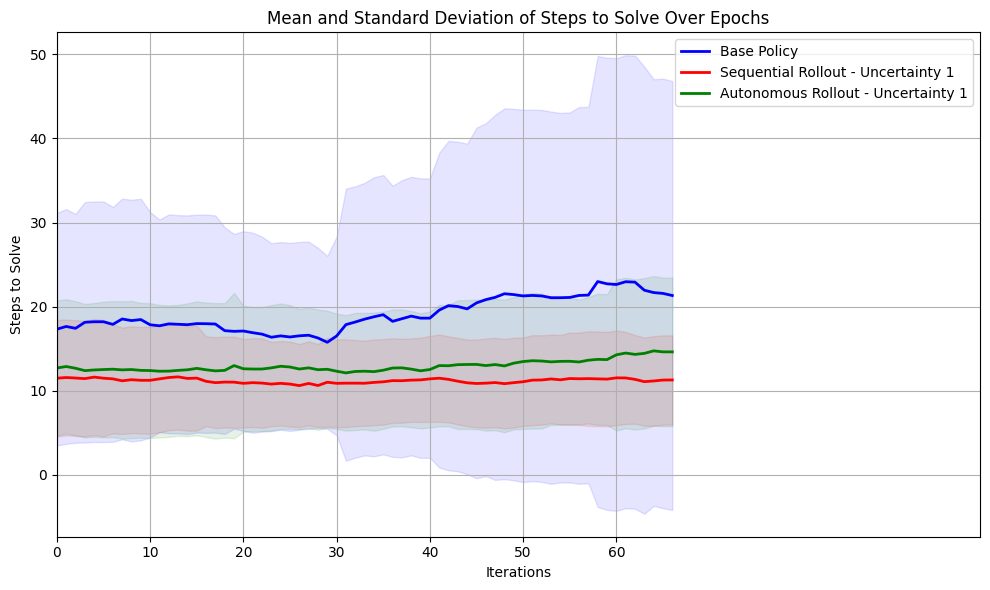

In [221]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import numpy as np

dfMode30BL = pd.read_csv('/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/Mode30_baselines.csv')
dfMode30_BasePolicy = dfMode30BL[["base policy - steps_to_solve","Step"]].copy()
dfMode30_ApprxSeq = dfMode30BL[["Approx Sig Sequential - steps_to_solve","Step"]].copy()
dfMode30_Seq = dfMode30BL[["Sequential - steps_to_solve","Step"]].copy()


# Assuming dfMode30_BasePolicy, dfMode30_ApprxSeq, dfMode30_Seq have 300 rows

# Calculate rolling mean and std for Base Policy with window size of 3
dfMode30_BasePolicy['base_policy_mean'] = dfMode30_BasePolicy['base policy - steps_to_solve'].rolling(window=100).mean()
dfMode30_BasePolicy['base_policy_std'] = dfMode30_BasePolicy['base policy - steps_to_solve'].rolling(window=100).std()

# Calculate rolling mean and std for Approx Sequential with window size of 3
dfMode30_ApprxSeq['approx_seq_mean'] = dfMode30_ApprxSeq['Approx Sig Sequential - steps_to_solve'].rolling(window=100).mean()
dfMode30_ApprxSeq['approx_seq_std'] = dfMode30_ApprxSeq['Approx Sig Sequential - steps_to_solve'].rolling(window=100).std()

# Calculate rolling mean and std for Sequential with window size of 3
dfMode30_Seq['seq_mean'] = dfMode30_Seq['Sequential - steps_to_solve'].rolling(window=100).mean()
dfMode30_Seq['seq_std'] = dfMode30_Seq['Sequential - steps_to_solve'].rolling(window=100).std()

# Drop the first two rows since rolling mean/std for window=3 will be NaN
dfMode30_BasePolicy = dfMode30_BasePolicy.dropna().reset_index(drop=True)
dfMode30_ApprxSeq = dfMode30_ApprxSeq.dropna().reset_index(drop=True)
dfMode30_Seq = dfMode30_Seq.dropna().reset_index(drop=True)

# Sampling every 3rd row to reduce from 300 rows to 100 rows
dfMode30_BasePolicy_grouped = dfMode30_BasePolicy[['base_policy_mean', 'base_policy_std']].iloc[::3].reset_index(drop=True)
dfMode30_ApprxSeq_grouped = dfMode30_ApprxSeq[['approx_seq_mean', 'approx_seq_std']].iloc[::3].reset_index(drop=True)
dfMode30_Seq_grouped = dfMode30_Seq[['seq_mean', 'seq_std']].iloc[::3].reset_index(drop=True)

# Renaming columns for consistency
dfMode30_BasePolicy_grouped = dfMode30_BasePolicy_grouped.rename(columns={'base_policy_mean': 'mean', 'base_policy_std': 'std'})
dfMode30_ApprxSeq_grouped = dfMode30_ApprxSeq_grouped.rename(columns={'approx_seq_mean': 'mean', 'approx_seq_std': 'std'})
dfMode30_Seq_grouped = dfMode30_Seq_grouped.rename(columns={'seq_mean': 'mean', 'seq_std': 'std'})


bPEpochs = list(range(dfMode30_BasePolicy_grouped.shape[0]))
bpMean = dfMode30_BasePolicy_grouped["mean"].to_list()
bpstd = dfMode30_BasePolicy_grouped["std"].to_list()
sqRollEpochs = list(range(dfMode30_Seq_grouped.shape[0]))
sqRollMean = dfMode30_Seq_grouped["mean"].to_list()
sqRollstd = dfMode30_Seq_grouped["std"].to_list()
ApproxSeqRollEpochs = list(range(dfMode30_ApprxSeq_grouped.shape[0]))
ApproxSeqRollMean = dfMode30_ApprxSeq_grouped["mean"].to_list()
ApproxSeqRollstd = dfMode30_ApprxSeq_grouped["std"].to_list()

bpColour = 'blue'
sqRollColour = 'red'
seqRandSigColour = 'cyan'
ApproxSeqRollColour = 'green'

def plot_with_shading(epochs, mean_values, std_values, color, label):
    """Function to plot mean with shaded standard deviation."""
    plt.plot(epochs, mean_values, color=color, label=label, linewidth=2)
    plt.fill_between(epochs, 
                     np.array(mean_values) - np.array(std_values), 
                     np.array(mean_values) + np.array(std_values), 
                     color=color, alpha=0.1, label=None)

epochs = [int(epoch) for epoch in bPEpochs]  # Ensure epochs are integers

plt.figure(figsize=(10, 6))
plot_with_shading(bPEpochs, bpMean, bpstd, bpColour, label='Base Policy')
plot_with_shading(sqRollEpochs, sqRollMean, sqRollstd, sqRollColour, label='Sequential Rollout - Uncertainty 1')
#plot_with_shading(seqRandSigEpochs, seqRandSigMean, seqRandSigstd, seqRandSigColour, label='Sequential RandSig')
plot_with_shading(ApproxSeqRollEpochs, ApproxSeqRollMean, ApproxSeqRollstd, ApproxSeqRollColour, label='Autonomous Rollout - Uncertainty 1')
plt.title('Mean and Standard Deviation of Steps to Solve Over Epochs')
plt.xlabel('Iterations')
plt.ylabel('Steps to Solve')
plt.legend()
plt.grid(True)
plt.xlim(0, 99)
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 10))
plt.tight_layout()
plt.show()

In [222]:
# Window 1 and 3 Baseline is the sequential rollout
window1Epoch = list(range(len(sqRollEpochs)))
window1Mean = sqRollMean
window1Std = sqRollstd

window3Epoch = sqRollEpochs
window3Mean = sqRollMean
window3Std = sqRollstd

In [223]:
# 2nd  window => uncertainty  = mode 15

In [289]:
def getDataFrame(inputFile):
    with open(inputFile, 'r') as file:
            data = json.load(file)
    listOfWholeTraining = []
    epochs = list(data.keys())
    
    i = 0
    for trainEpoch in epochs:
        epochData = data[str(trainEpoch)]
        for indData in epochData:
            steps = indData['StepsToSolve']
            listOfWholeTraining.append({"episode": i, "steps": steps})
            i += 1
    dfNoAvg = pd.DataFrame(listOfWholeTraining)
    return dfNoAvg


def getMean_STD(inputFile):
    with open(inputFile, 'r') as file:
        data = json.load(file)
    listOfWholeTraining = []
    
    epochs = list(data.keys())
    i = 0
    ruleBasedResultsPlot_mean = []
    ruleBasedResultsPlot_std = []
    for trainEpoch in epochs:
        listofSteps = []
        epochData = data[str(trainEpoch)]
        for indData in epochData:
            steps = indData['StepsToSolve']
            listofSteps.append(steps)
            listOfWholeTraining.append({"episode": i, "steps": steps})
            i += 1
        ruleBasedResultsPlot_mean.append(np.mean(listofSteps))    
        ruleBasedResultsPlot_std.append(np.std(listofSteps))  
    return epochs, ruleBasedResultsPlot_mean, ruleBasedResultsPlot_std


def getMean_STD2(inputFile):
    with open(inputFile, 'r') as file:
        data = json.load(file)
    listOfWholeTraining = []
    
    epochs = list(data.keys())
    i = 0
    ruleBasedResultsPlot_mean = []
    ruleBasedResultsPlot_std = []
    for trainEpoch in epochs:
        listofSteps = []
        epochData = data[str(trainEpoch)]
        for indData in epochData:
            steps = indData['StepsToSolve']
            listofSteps.append(steps)
            listOfWholeTraining.append({"episode": i, "steps": steps})
            i += 1
        ruleBasedResultsPlot_mean.append(np.mean(listofSteps))    
        ruleBasedResultsPlot_std.append(np.std(listofSteps))  
    return epochs, ruleBasedResultsPlot_mean, ruleBasedResultsPlot_std, listOfWholeTraining


In [225]:
mode15_SequentialResults = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/results_experiment_sequential_rollout.json'
sqRollEpochs, sqRollMean, sqRollstd = getMean_STD(mode15_SequentialResults)

In [226]:
# Baseline is the sequential rollout
window2Epoch = sqRollEpochs
window2Mean = sqRollMean
window2Std = sqRollstd

<h3>Plot Window 1 Agent Behaviour</h3>

In [544]:
window1_modelData = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/Approx_Seq_New_15.json'
window1_modelEpochs, window1_modelMean, window1_modelstd = getMean_STD(window1_modelData)
window1_modelEpochs = list(range(len(window1_modelEpochs)))
agentModelColour = 'green'
if len(window1_modelEpochs) > len(window1Epoch):
    window1_modelEpochs = window1_modelEpochs[0:len(window1Epoch)]
    window1_modelMean = window1_modelMean[0:len(window1Epoch)]
    window1_modelstd = window1_modelstd[0:len(window1Epoch)]


<h3>Plot Window 2 Agent Behaviour</h3>

In [545]:
# adaptation models from 30

cross_30_0 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__0.json'
cross_30_1 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__1.json'
cross_30_2 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__2.json'
cross_30_3 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__3.json'
cross_30_4 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__4.json'
cross_30_5 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__5.json'
cross_30_6 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__6.json'
cross_30_7 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__7.json'
cross_30_8 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode15-dqn/adaptation_models_from_30/cross_rollout_mode30__8.json'


cross30_0_Epochs, cross30_0_Mean, cross30_0_Mstd = getMean_STD(cross_30_0)
cross30_1_Epochs, cross30_1_Mean, cross30_1_Mstd = getMean_STD(cross_30_1)
cross30_2_Epochs, cross30_2_Mean, cross30_2_Mstd = getMean_STD(cross_30_2)
cross30_3_Epochs, cross30_3_Mean, cross30_3_Mstd = getMean_STD(cross_30_3)
cross30_4_Epochs, cross30_4_Mean, cross30_4_Mstd = getMean_STD(cross_30_4)
cross30_5_Epochs, cross30_5_Mean, cross30_5_Mstd = getMean_STD(cross_30_5)
cross30_6_Epochs, cross30_6_Mean, cross30_6_Mstd = getMean_STD(cross_30_6)
cross30_7_Epochs, cross30_7_Mean, cross30_7_Mstd = getMean_STD(cross_30_7)
cross30_8_Epochs, cross30_8_Mean, cross30_8_Mstd = getMean_STD(cross_30_8)

start_value = len(window1_modelEpochs)
end_value = len(cross30_mean_total) + start_value-1
window2_modelEpochs = list(range(start_value, end_value + 1))

window2_modelMean = cross30_0_Mean + cross30_1_Mean + cross30_2_Mean + cross30_3_Mean + cross30_4_Mean + cross30_5_Mean + cross30_6_Mean + cross30_7_Mean + cross30_8_Mean + cross30_8_Mean
window2_modelstd = cross30_0_Mstd + cross30_1_Mstd + cross30_2_Mstd + cross30_3_Mstd + cross30_4_Mstd + cross30_5_Mstd + cross30_6_Mstd + cross30_7_Mstd + cross30_8_Mstd + cross30_8_Mstd


<h3>Plot Window 3 Agent Behaviour</h3>

(67,)
(67,)


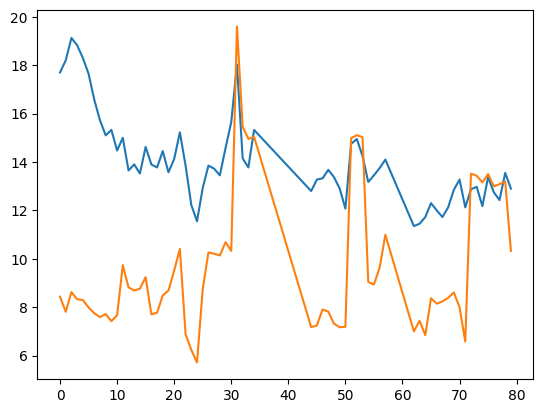

In [546]:
cross_30_15_30_0 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__0 (1).json'
cross_30_15_30_1 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__1 (1).json'
cross_30_15_30_2 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__2 (1).json'
cross_30_15_30_3 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__3 (1).json'
cross_30_15_30_4 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__4 (1).json'
cross_30_15_30_5 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__5 (1).json'
cross_30_15_30_6 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__6 (1).json'
cross_30_15_30_7 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__7 (1).json'
cross_30_15_30_8 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__8 (1).json'

dataFilesList = [cross_30_15_30_0, cross_30_15_30_1, cross_30_15_30_2, cross_30_15_30_3, cross_30_15_30_4, cross_30_15_30_5, cross_30_15_30_6, cross_30_15_30_7, cross_30_15_30_8]



cross30_15_30_Epochs_Total = []
window3_modelMean = []
window3_modelstd = []
for dataFile in dataFilesList:
    cross30_15_30_Epochs, cross30_15_30_Mean, cross30_15_30_std, listofTraining = getMean_STD2(dataFile)
    dfTraining = pd.DataFrame(listofTraining)
    dfTraining['smoothMean'] = dfTraining['steps'].rolling(window=40).mean()
    dfTraining['smoothSTD'] = dfTraining['steps'].rolling(window=40).std()
    dfTraining = dfTraining.dropna()
    
    
    
    
    cross30_15_30_Epochs_Total = cross30_15_30_Epochs_Total + cross30_15_30_Epochs
    window3_modelMean += list(dfTraining["smoothMean"])
    window3_modelstd += list(dfTraining["smoothSTD"])


sampleIndex = 6


dfwindow3_modelMean = pd.DataFrame(window3_modelMean).iloc[::sampleIndex, :].reset_index()
dfwindow3_modelMean['smoothMean'] = dfwindow3_modelMean[0].rolling(window=1).mean()
dfwindow3_modelMean = dfwindow3_modelMean.iloc[0:80]
dfwindow3_modelMean = pd.concat([dfwindow3_modelMean.iloc[0:35], dfwindow3_modelMean.iloc[44:58], dfwindow3_modelMean.iloc[62:80]])
del dfwindow3_modelMean["index"]
dfwindow3_modelMean = dfwindow3_modelMean['smoothMean'].dropna()
print(dfwindow3_modelMean.shape)
plt.plot(dfwindow3_modelMean)

dfwindow3_modelStd = pd.DataFrame(window3_modelstd).iloc[::sampleIndex, :].reset_index()
dfwindow3_modelStd['smoothMean'] = dfwindow3_modelStd[0].rolling(window=1).mean()
dfwindow3_modelStd = dfwindow3_modelStd.iloc[0:80]
dfwindow3_modelStd = pd.concat([dfwindow3_modelStd.iloc[0:35], dfwindow3_modelStd.iloc[44:58], dfwindow3_modelStd.iloc[62:80]])
del dfwindow3_modelStd["index"]
dfwindow3_modelStd = dfwindow3_modelStd['smoothMean'].dropna()
print(dfwindow3_modelStd.shape)
plt.plot(dfwindow3_modelStd)

window3_modelMean = list(dfwindow3_modelMean)
window3_modelstd = list(dfwindow3_modelStd)

start_value = len(window1_modelEpochs+window2_modelEpochs)
end_value = len(window3_modelstd) + start_value-1
window3_modelEpochs = list(range(start_value, end_value + 1))

<h3>Plot Baselines</h3>

In [547]:
totalepochs = list(range(len(window1Epoch+window2Epoch+window3Epoch)))
totalMean = window1Mean + window2Mean + window3Mean
totalStd = window1Std + window2Std + window3Std
BaseLineColour = 'red'

In [548]:
len(window3_modelEpochs)

67

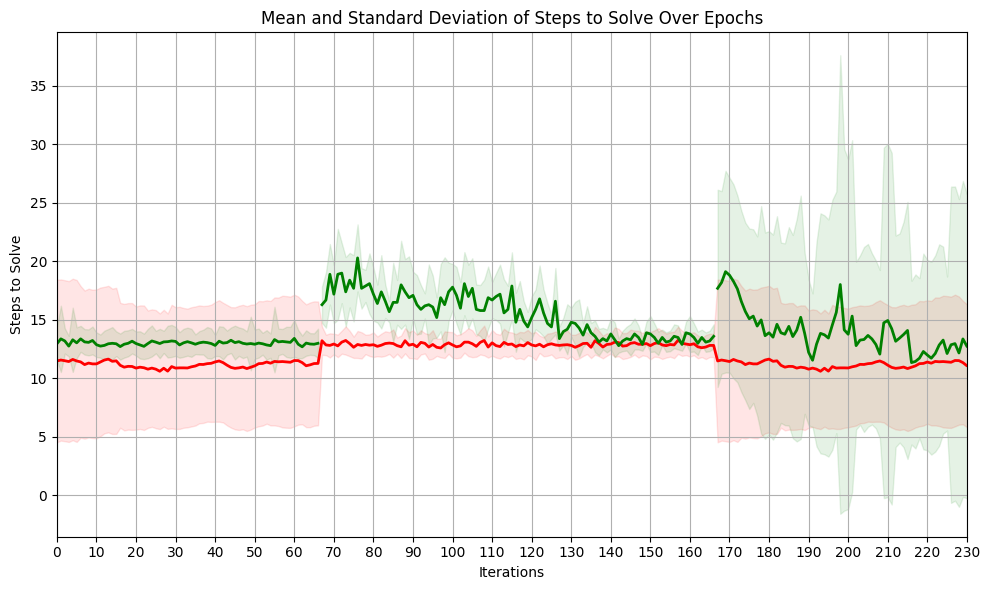

In [549]:

def plot_with_shading(epochs, mean_values, std_values, color, label):
    """Function to plot mean with shaded standard deviation."""
    plt.plot(epochs, mean_values, color=color, label=label, linewidth=2)
    plt.fill_between(epochs, 
                     np.array(mean_values) - np.array(std_values), 
                     np.array(mean_values) + np.array(std_values), 
                     color=color, alpha=0.1, label=None)

epochs = [int(epoch) for epoch in totalepochs]  # Ensure epochs are integers

plt.figure(figsize=(10, 6))
plot_with_shading(totalepochs, totalMean, totalStd, BaseLineColour, label='')
plot_with_shading(window1_modelEpochs, window1_modelMean, window1_modelstd, agentModelColour, label='')
plot_with_shading(window2_modelEpochs, window2_modelMean, window2_modelstd, agentModelColour, label='')
plot_with_shading(window3_modelEpochs, window3_modelMean, window3_modelstd, agentModelColour, label='')
plt.title('Mean and Standard Deviation of Steps to Solve Over Epochs')
plt.xlabel('Iterations')
plt.ylabel('Steps to Solve')
plt.grid(True)
plt.xlim(0, 99)
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 10))
plt.tight_layout()
plt.show()

In [480]:
len(window1_modelMean), len(window3_modelMean)

(67, 67)

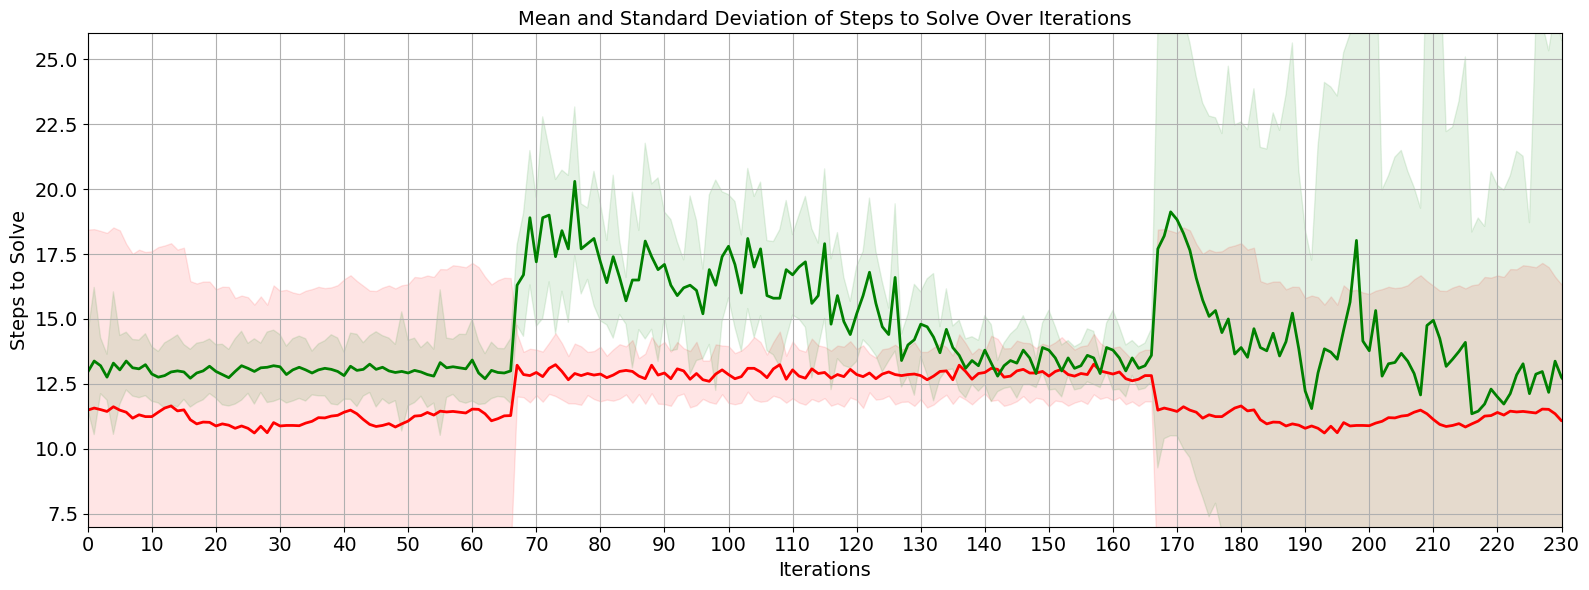

In [550]:
def plot_with_shading(epochs, mean_values, std_values, color, label):
    """Function to plot mean with shaded standard deviation."""
    plt.plot(epochs, mean_values, color=color, label=label, linewidth=2)
    plt.fill_between(epochs, 
                     np.array(mean_values) - np.array(std_values), 
                     np.array(mean_values) + np.array(std_values), 
                     color=color, alpha=0.1, label=None)

epochs = [int(epoch) for epoch in totalepochs]  # Ensure epochs are integers

plt.figure(figsize=(16, 6))
plot_with_shading(totalepochs, totalMean, totalStd, BaseLineColour, label='')
plot_with_shading(window1_modelEpochs+window2_modelEpochs+window3_modelEpochs, window1_modelMean+window2_modelMean+window3_modelMean, window1_modelstd+window2_modelstd+window3_modelstd, agentModelColour, label='')
plt.title('Mean and Standard Deviation of Steps to Solve Over Iterations', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Steps to Solve', fontsize=14)
plt.grid(True)
plt.xlim(0, 99)
plt.ylim(7, 26)
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 10), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [551]:
def plot_with_shading(epochs, mean_values, std_values, color, label):
    """Function to plot mean with shaded standard deviation."""
    plt.plot(epochs, mean_values, color=color, label=label, linewidth=2)
    plt.fill_between(epochs, 
                     np.array(mean_values) - np.array(std_values), 
                     np.array(mean_values) + np.array(std_values), 
                     color=color, alpha=0.1, label=None)

epochs = [int(epoch) for epoch in totalepochs]  # Ensure epochs are integers

# Prepare the figure
plt.figure(figsize=(16, 6))


# Loop to plot each point of the green line incrementally
for i in range(1, len(window1_modelEpochs + window2_modelEpochs + window3_modelEpochs) + 1):
    plot_with_shading(totalepochs, totalMean, totalStd, BaseLineColour, label='')
    # Plot up to the i-th point in the green line data
    combined_epochs = window1_modelEpochs + window2_modelEpochs + window3_modelEpochs
    combined_mean = window1_modelMean + window2_modelMean + window3_modelMean
    combined_std = window1_modelstd + window2_modelstd + window3_modelstd

    # Plot the green line incrementally
    plot_with_shading(combined_epochs[:i], combined_mean[:i], combined_std[:i], agentModelColour, label='')

    # Customize the plot
    plt.title('Mean and Standard Deviation of Steps to Solve Over Iterations', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Steps to Solve', fontsize=14)
    plt.grid(True)
    plt.xlim(0, 99)
    plt.ylim(7, 26)
    plt.xticks(np.arange(min(epochs), max(epochs) + 1, 10), fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Save each figure as an image
    plt.savefig(f"./adaptation_files/line/frame_{i}.png")

    # Optional: Clear the plot to avoid overlapping lines in the next iteration
    plt.clf()

    # Show the final plot
plt.show()


<Figure size 1600x600 with 0 Axes>

In [243]:
6*1350/500

16.2

<h3>Plot Histograms Window 2</h3>

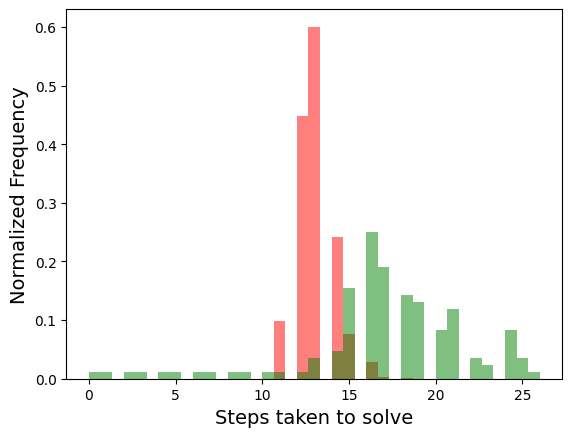

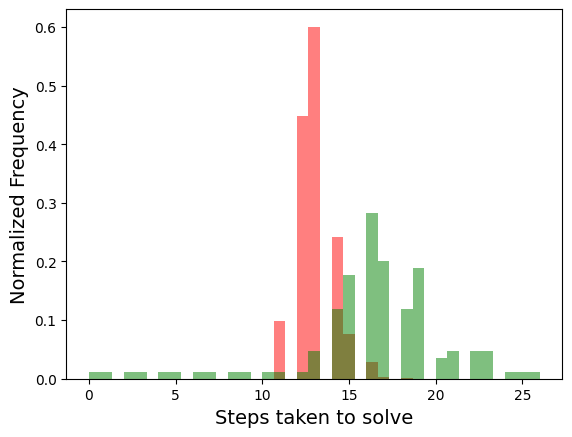

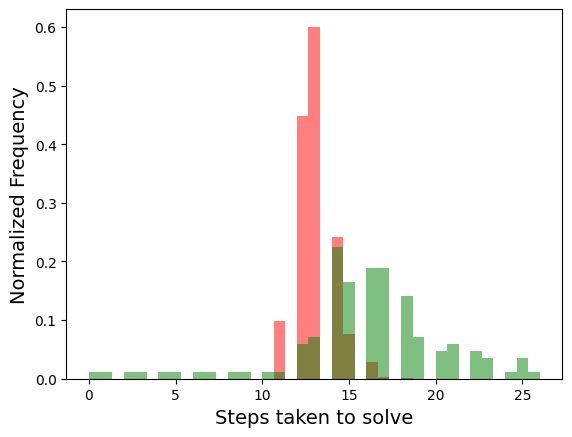

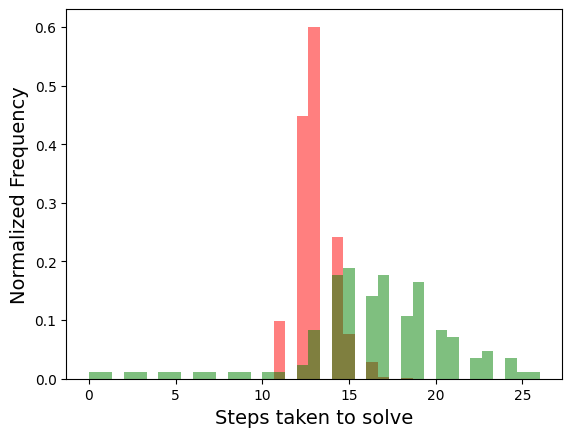

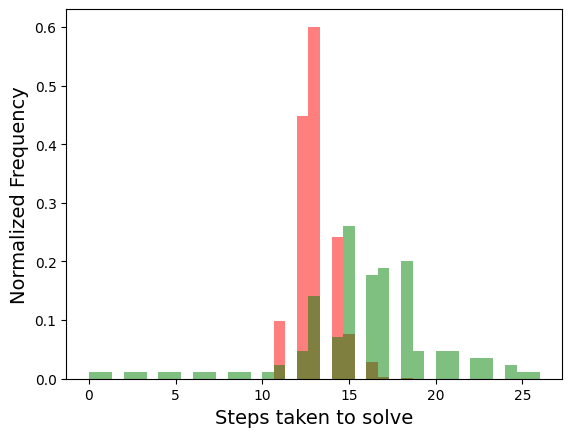

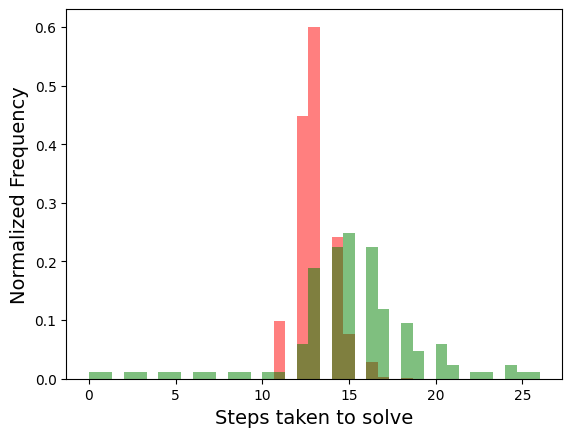

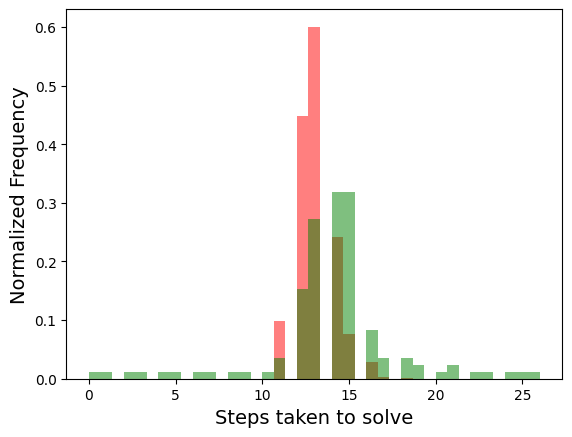

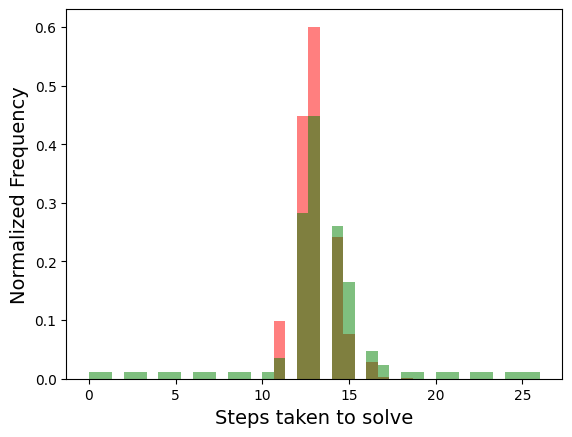

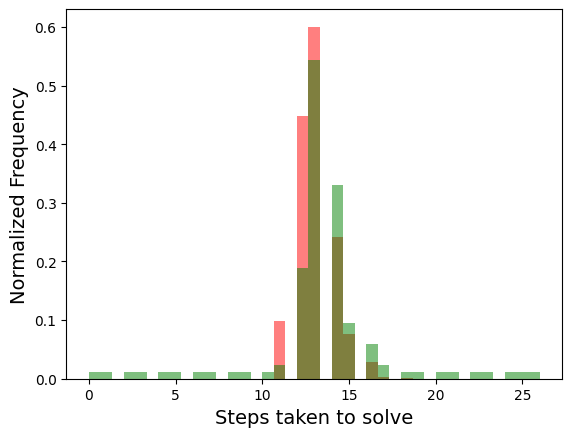

In [525]:
import matplotlib.pyplot as plt
import numpy as np


dfwindow2_baseline = getDataFrame(mode15_SequentialResults)

dfwindow2_model_0 = getDataFrame(cross_30_0)
dfwindow2_model_1 = getDataFrame(cross_30_1)
dfwindow2_model_2 = getDataFrame(cross_30_2)
dfwindow2_model_3 = getDataFrame(cross_30_3)
dfwindow2_model_4 = getDataFrame(cross_30_4)
dfwindow2_model_5 = getDataFrame(cross_30_5)
dfwindow2_model_6 = getDataFrame(cross_30_6)
dfwindow2_model_7 = getDataFrame(cross_30_7)
dfwindow2_model_8 = getDataFrame(cross_30_8)


data_window2 = [dfwindow2_model_0, dfwindow2_model_1, dfwindow2_model_2, dfwindow2_model_3, dfwindow2_model_4, dfwindow2_model_5 ,dfwindow2_model_6,dfwindow2_model_7,dfwindow2_model_8]
maxStepCount = -2000
for dataInd in data_window2:
    
    maxVal = dataInd["steps"].max()
    if maxVal >maxStepCount :
        maxStepCount = maxVal

if dfwindow2_baseline["steps"].max() > maxStepCount:
    maxStepCount = dfwindow2_baseline["steps"].max()


bin_edges = np.linspace(0, 26, 40)  # 50 bins

for epoccc in range(9):
    epochPLot = epoccc
    plt.hist(dfwindow2_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Sequential Rollout', color='red', density=True)
    plt.hist(data_window2[epochPLot].values.flatten(), bins=bin_edges, alpha=0.5, label='Autonomous MA Rollout', color='green', density=True)
    
    # Add labels and title
    plt.xlabel('Steps taken to solve', fontsize=14)
    plt.ylabel('Normalized Frequency', fontsize=14)
    
    # Add a legend
    #plt.legend()
    
    plt.savefig(f'./adaptation_files/window2_histogram_plot_{epochPLot}.png', format='png')
    # Show the plot
    plt.show()




In [234]:
dfwindow2_model_0

,episode,steps
0,0,16
1,1,17
2,2,19
3,3,19
4,4,14
...,...,...
95,95,21
96,96,19
97,97,21
98,98,16


<h3>Plot Histograms Window 1</h3>

In [235]:
dfMode30BL = pd.read_csv('/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/Mode30_baselines.csv')
dfMode30_ApprxSeq = dfMode30BL[["Approx Sig Sequential - steps_to_solve","Step"]].copy()
dfwindow1_model = dfMode30_ApprxSeq.rename(columns={'Step': 'episode', 'Approx Sig Sequential - steps_to_solve': 'steps'})

In [236]:
dfMode30_Seq = dfMode30BL[["Sequential - steps_to_solve","Step"]].copy()
dfwindow1_baseline = dfMode30_Seq.rename(columns={'Step': 'episode', 'Sequential - steps_to_solve': 'steps'})

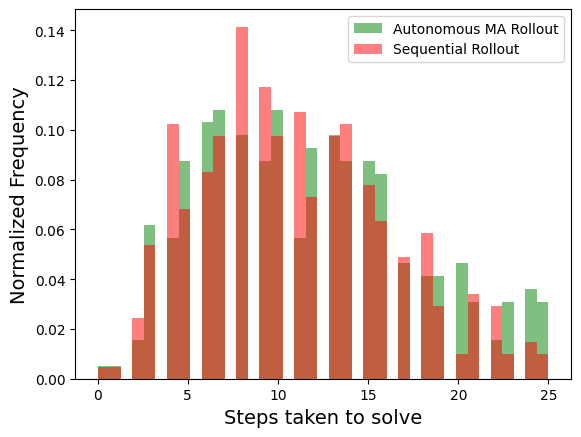

In [557]:
import matplotlib.pyplot as plt
import numpy as np

bin_edges = np.linspace(0, 25, 40)  # 50 bins

dfwindow1_baseline = dfwindow1_baseline.loc[dfwindow1_baseline["steps"]<=44]
plt.hist(dfwindow1_model.values.flatten(), bins=bin_edges, alpha=0.5, label='Autonomous MA Rollout', color='green', density=True)
plt.hist(dfwindow1_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Sequential Rollout', color='red', density=True)

# Add labels and title
plt.xlabel('Steps taken to solve', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)

# Add a legend
plt.legend()

plt.savefig('./adaptation_files/window1.png')
# Show the plot
plt.show()


In [556]:
dfwindow1_baseline.max()

steps       44
episode    299
dtype: int64

<h3>Plot Histograms Window 3</h3>

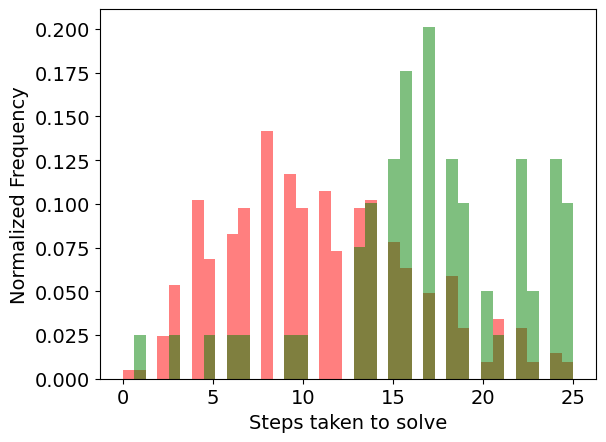

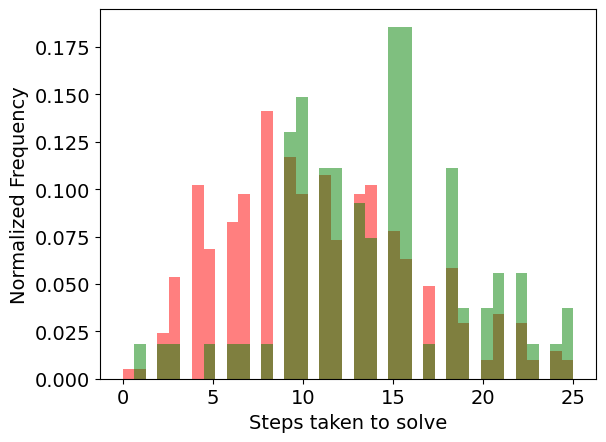

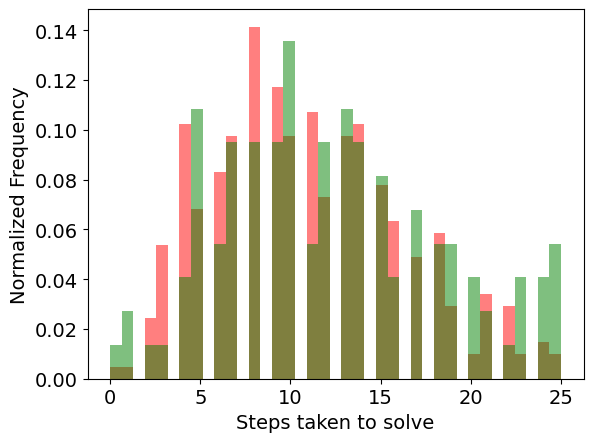

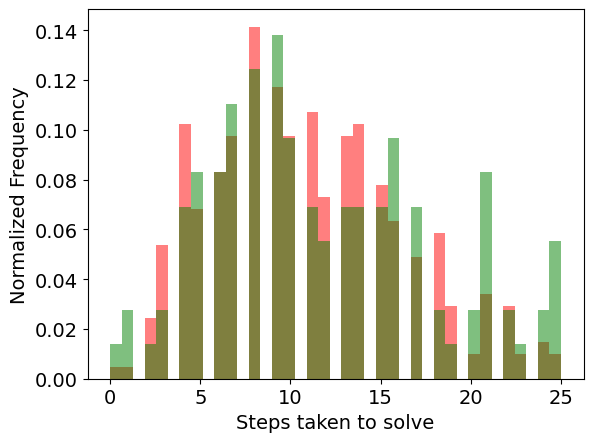

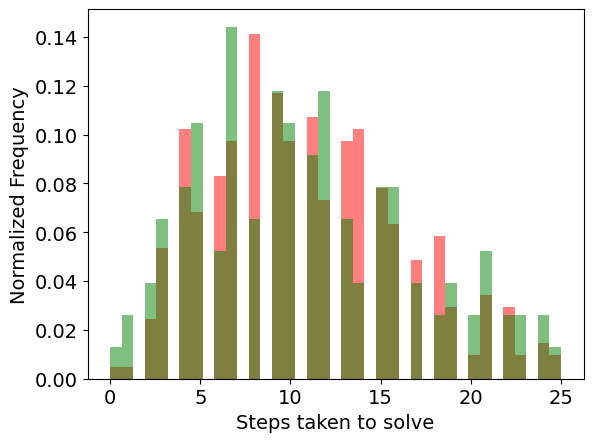

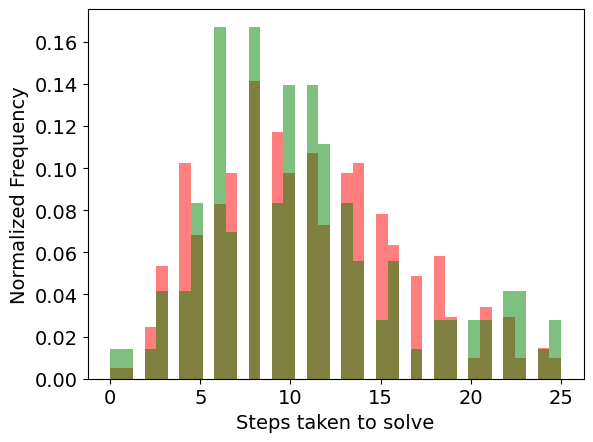

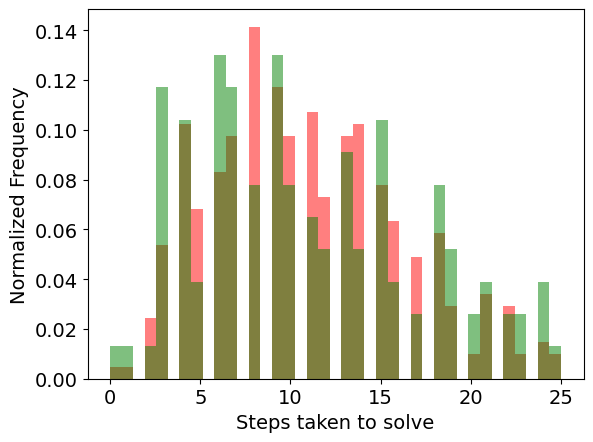

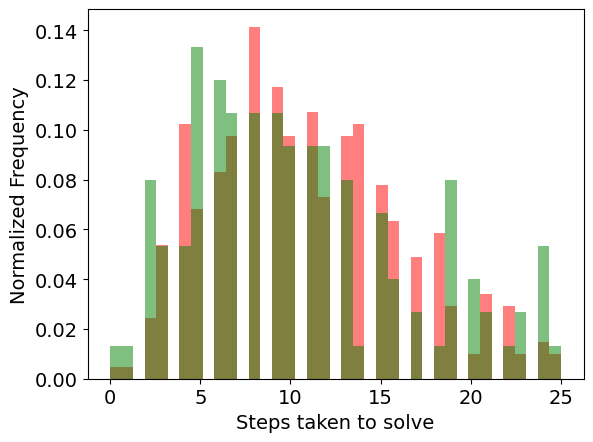

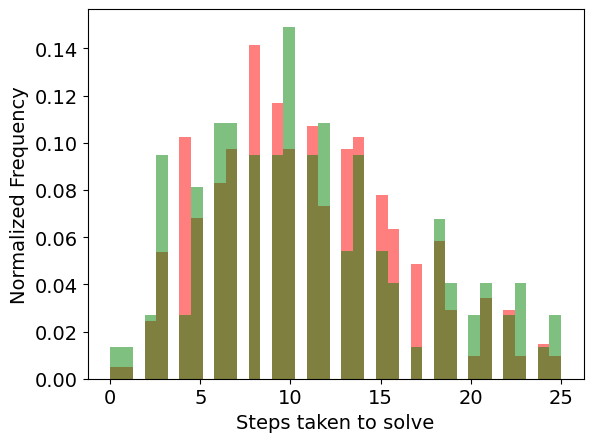

In [575]:
import matplotlib.pyplot as plt
import numpy as np

dfwindow1_baseline = dfwindow1_baseline.loc[dfwindow1_baseline["steps"]<=44]
dfwindow3_baseline = dfwindow1_baseline
dataFilesList = [cross_30_15_30_0, cross_30_15_30_1, cross_30_15_30_2, cross_30_15_30_3, cross_30_15_30_4, cross_30_15_30_5, cross_30_15_30_6, cross_30_15_30_7, cross_30_15_30_8]

listofDFs_window3 = []
for dataIndFile in dataFilesList:
    dfwindow2_model_i  = getDataFrame(dataIndFile)
    listofDFs_window3.append(dfwindow2_model_i)
    

maxStepCount = -2000
for dataInd in listofDFs_window3:
    maxVal = dataInd["steps"].max()
    if maxVal >maxStepCount :
        maxStepCount = maxVal

if dfwindow3_baseline["steps"].max() > maxStepCount:
    maxStepCount = dfwindow3_baseline["steps"].max()


bin_edges = np.linspace(0, 25, 40)  # 50 bins

for epoccc in range(9):
    epochPLot = epoccc
    dfDrwaw = listofDFs_window3[epochPLot]
    if epoccc == 0 :
        dfDrwaw = dfDrwaw.loc[dfDrwaw["steps"]>12]

    if epoccc == 1 :
        dfDrwaw = dfDrwaw.loc[dfDrwaw["steps"]>8]
    plt.hist(dfwindow3_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Sequential Rollout', color='red', density=True)
    plt.hist(dfDrwaw.values.flatten(), bins=bin_edges, alpha=0.5, label='Autonomous MA Rollout', color='green', density=True)
    
    
    # Add labels and title
    plt.xlabel('Steps taken to solve', fontsize=14)
    plt.ylabel('Normalized Frequency', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add a legend
    #plt.legend()
    
    plt.savefig(f'./adaptation_files/FixedAvg_window_3_histogram_plot_{epochPLot}.png', format='png')
    # Show the plot
    plt.show()



In [272]:
dfwindow3_baseline, dfwindow1_baseline

(     steps  episode
 0        5        0
 1        4        1
 2        4        2
 3       10        3
 4        7        4
 ..     ...      ...
 295     19      295
 296     14      296
 297     11      297
 298      5      298
 299     14      299
 
 [300 rows x 2 columns],
      steps  episode
 0        5        0
 1        4        1
 2        4        2
 3       10        3
 4        7        4
 ..     ...      ...
 295     19      295
 296     14      296
 297     11      297
 298      5      298
 299     14      299
 
 [300 rows x 2 columns])

<h3>Merge all historgrams in one x axis</h3>

In [239]:
totalDFs = [dfwindow1_model,dfwindow1_baseline, dfwindow2_baseline, dfwindow3_baseline] + data_window2 + listofDFs_window3

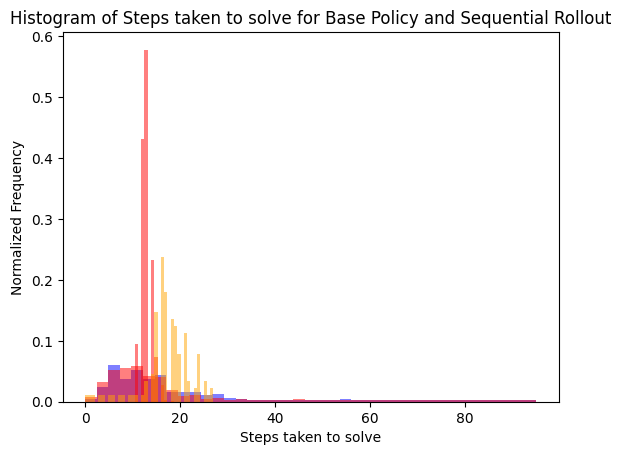

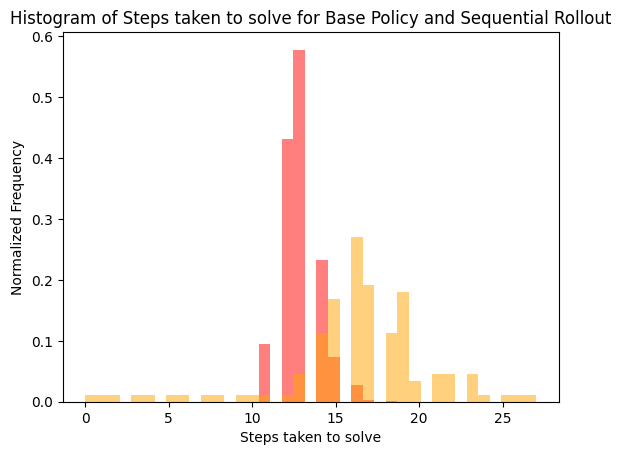

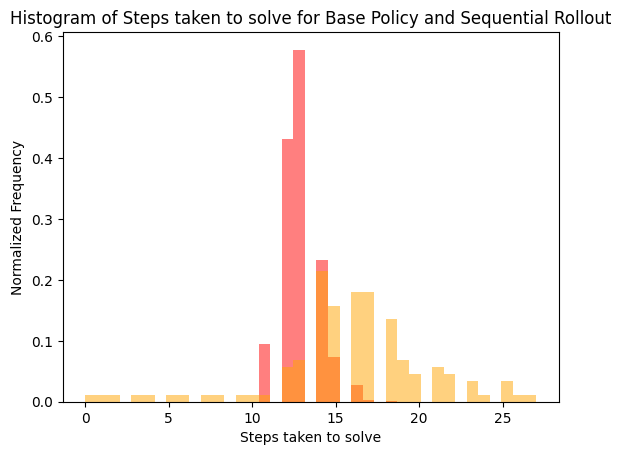

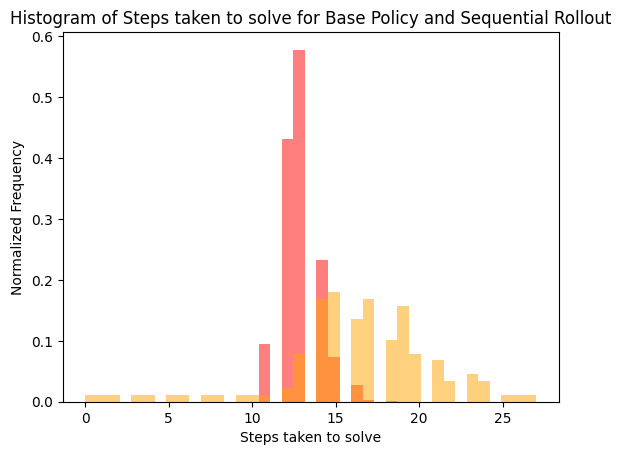

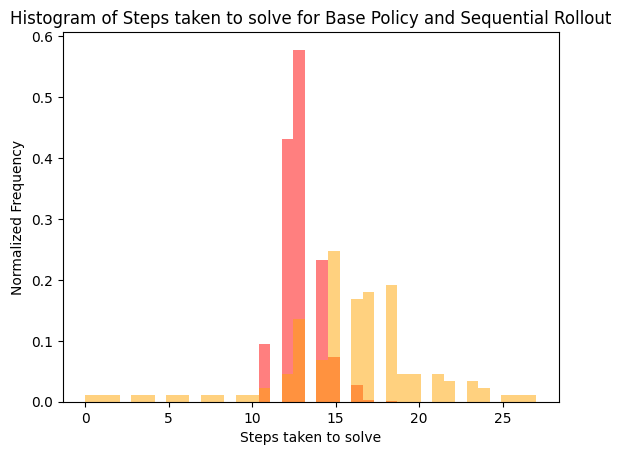

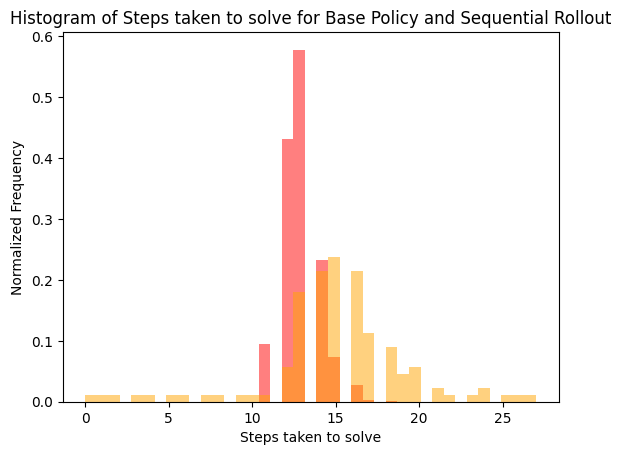

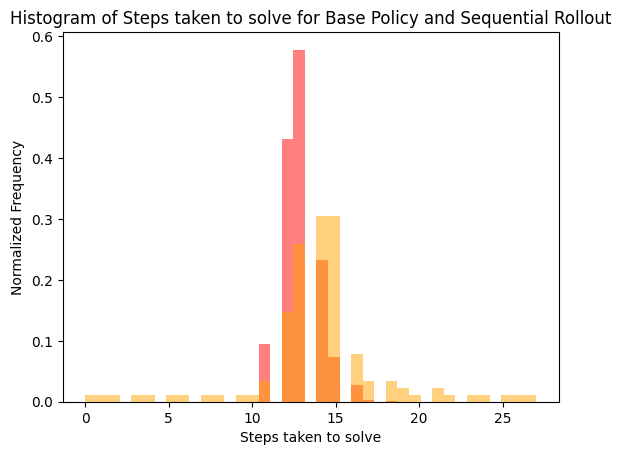

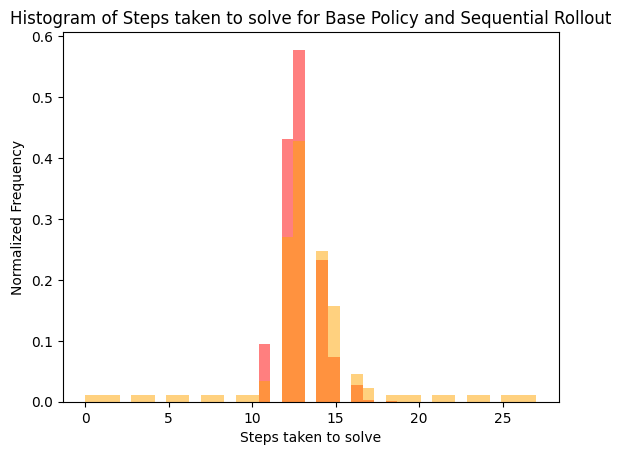

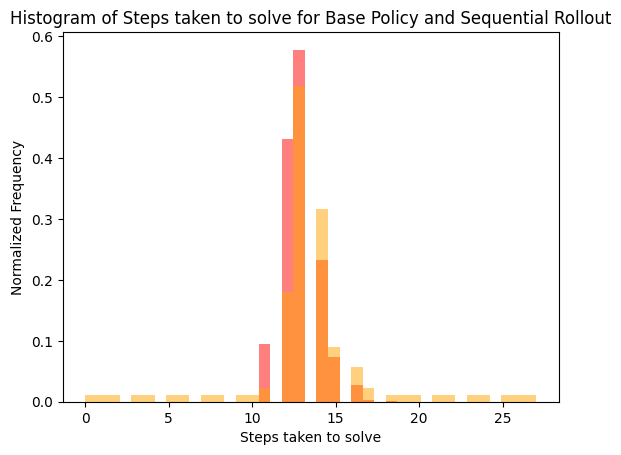

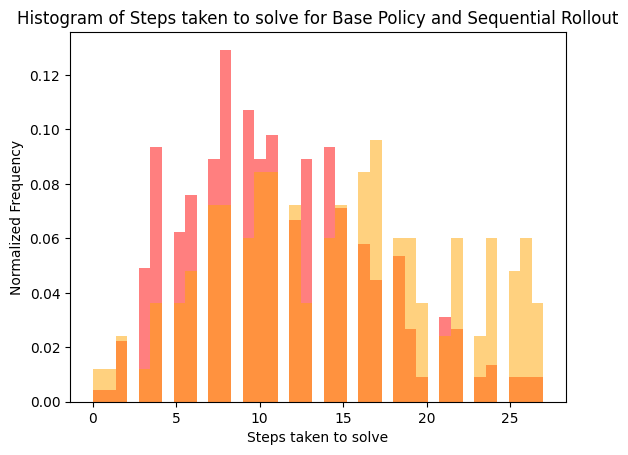

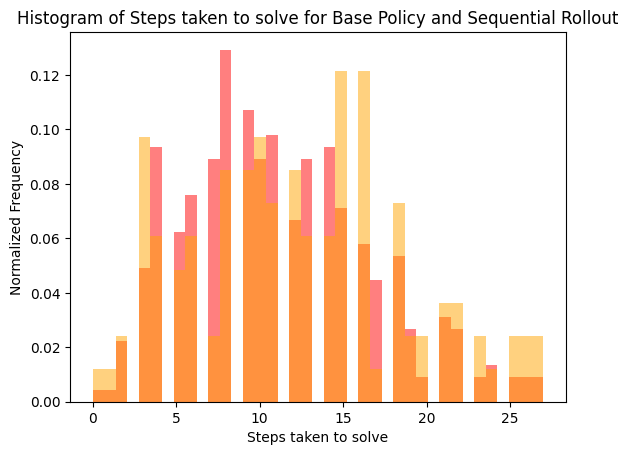

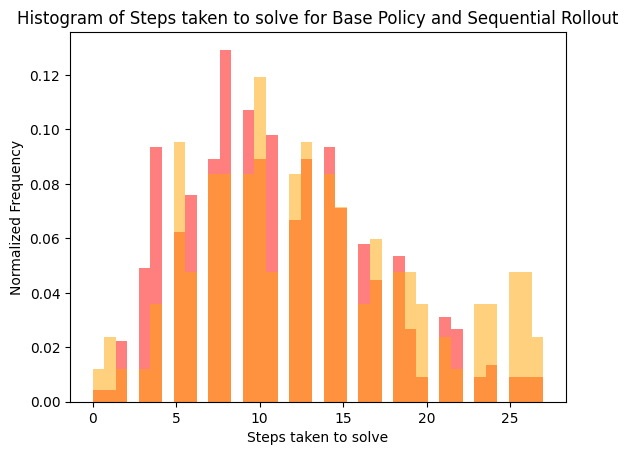

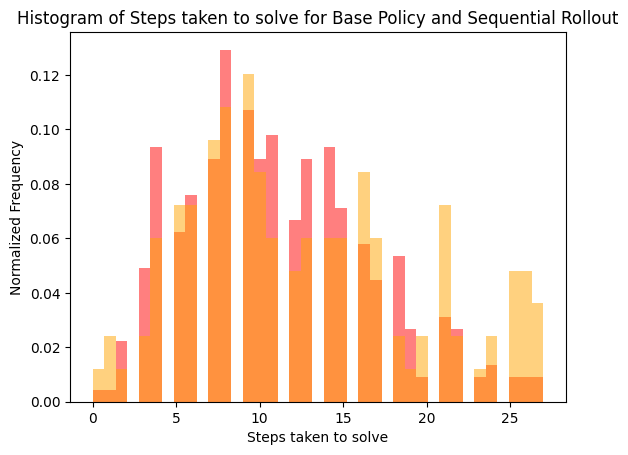

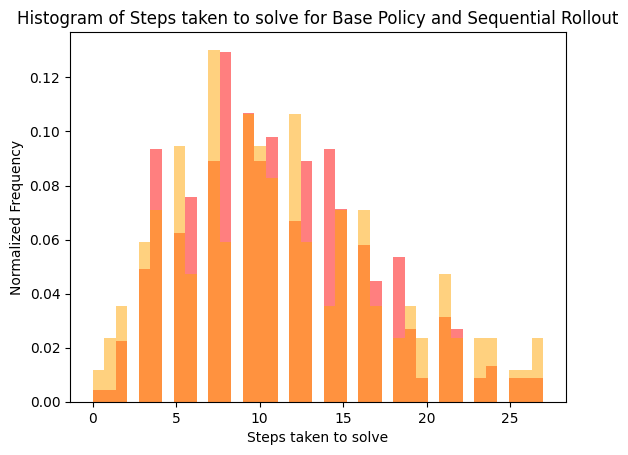

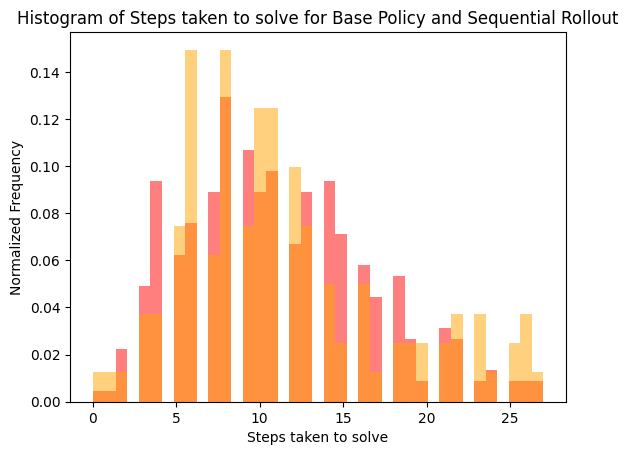

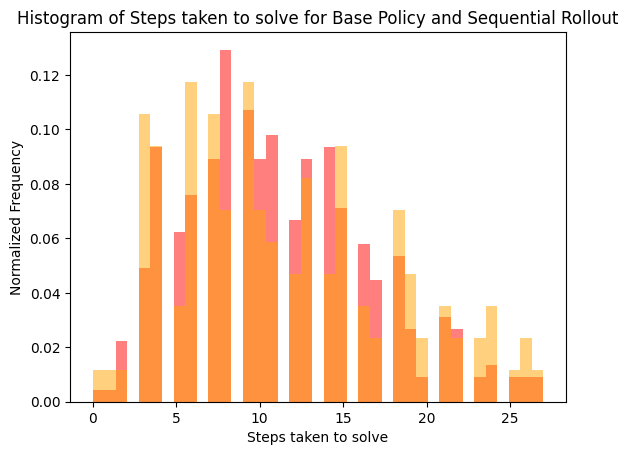

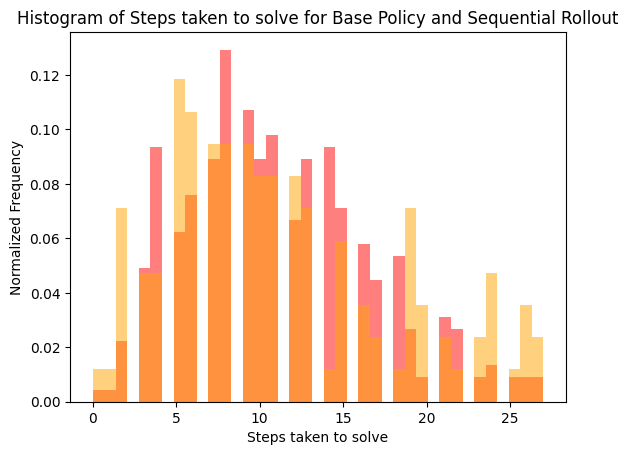

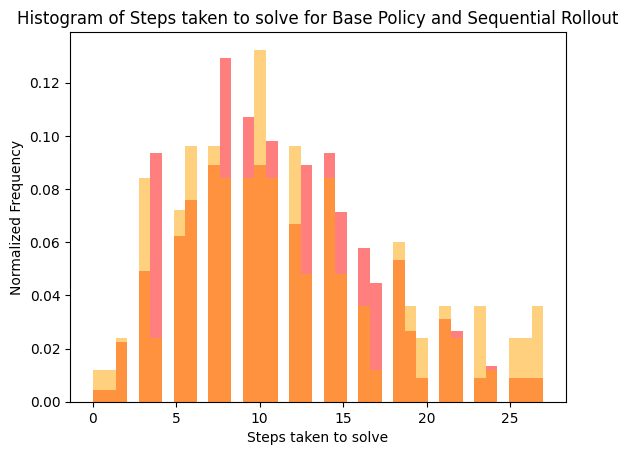

In [240]:

# window 1
plt.hist(dfwindow1_model.values.flatten(), bins=bin_edges, alpha=0.5, label='Base Policy', color='blue', density=True)
plt.hist(dfwindow1_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Sequential Rollout', color='red', density=True)


# window 2
data_window2 = [dfwindow2_model_0, dfwindow2_model_1, dfwindow2_model_2, dfwindow2_model_3, dfwindow2_model_4, dfwindow2_model_5 ,dfwindow2_model_6,dfwindow2_model_7,dfwindow2_model_8]
maxStepCount = -2000
for dataInd in data_window2:
    
    maxVal = dataInd["steps"].max()
    if maxVal >maxStepCount :
        maxStepCount = maxVal

if dfwindow2_baseline["steps"].max() > maxStepCount:
    maxStepCount = dfwindow2_baseline["steps"].max()


bin_edges = np.linspace(0, maxStepCount, 40)  # 50 bins

for epoccc in range(9):
    epochPLot = epoccc
    plt.hist(dfwindow2_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Seq Roll', color='red', density=True)
    plt.hist(data_window2[epochPLot].values.flatten(), bins=bin_edges, alpha=0.5, label=f'Cross from 30 - epoch {epochPLot}', color='orange', density=True)
    
    # Add labels and title
    plt.xlabel('Steps taken to solve')
    plt.ylabel('Normalized Frequency')
    plt.title('Histogram of Steps taken to solve for Base Policy and Sequential Rollout')
    
    # Add a legend
    #plt.legend()
    
    #plt.savefig(f'adapting_histogram/histogram_plot_{epochPLot}.png', format='png')
    # Show the plot
    plt.show()


# window 3


bin_edges = np.linspace(0, maxStepCount, 40)  # 50 bins

for epoccc in range(9):
    epochPLot = epoccc
    plt.hist(dfwindow3_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Seq Roll', color='red', density=True)
    plt.hist(listofDFs_window3[epochPLot].values.flatten(), bins=bin_edges, alpha=0.5, label=f'Cross from 30 - epoch {epochPLot}', color='orange', density=True)
    
    # Add labels and title
    plt.xlabel('Steps taken to solve')
    plt.ylabel('Normalized Frequency')
    plt.title('Histogram of Steps taken to solve for Base Policy and Sequential Rollout')
    
    # Add a legend
    #plt.legend()
    
    #plt.savefig(f'adapting_histogram/histogram_plot_{epochPLot}.png', format='png')
    # Show the plot
    plt.show()


<h3>Create histogram for window 3 for </h3>

(100, 2)


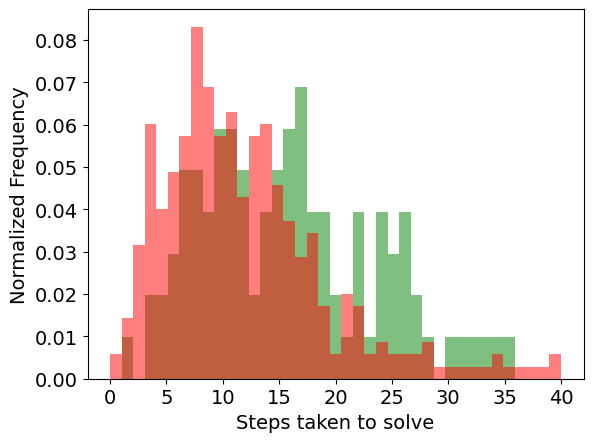

(100, 2)


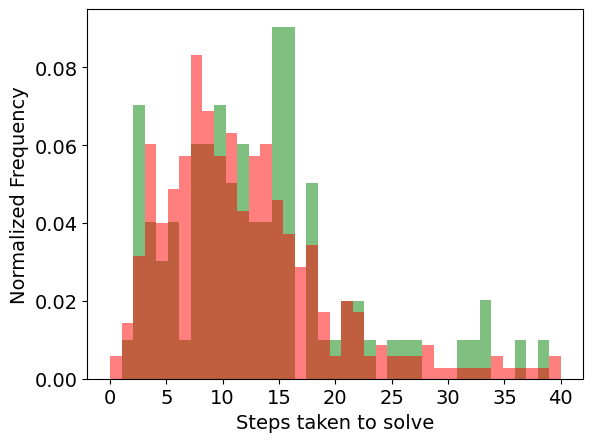

(100, 2)


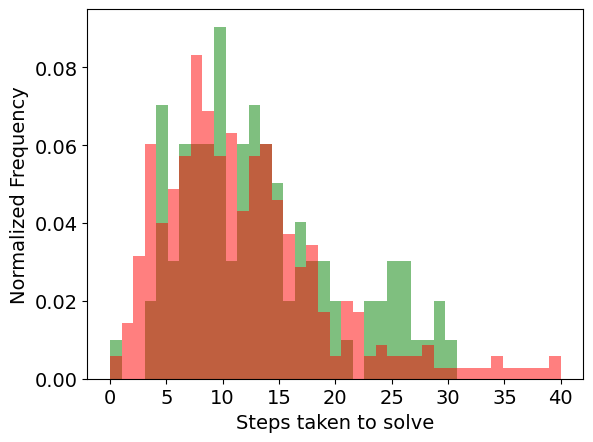

(100, 2)


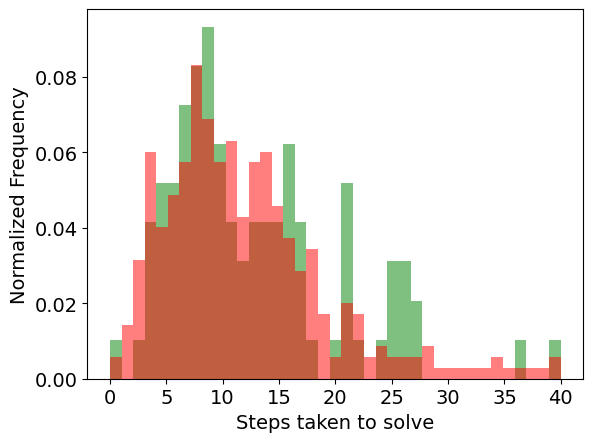

(100, 2)


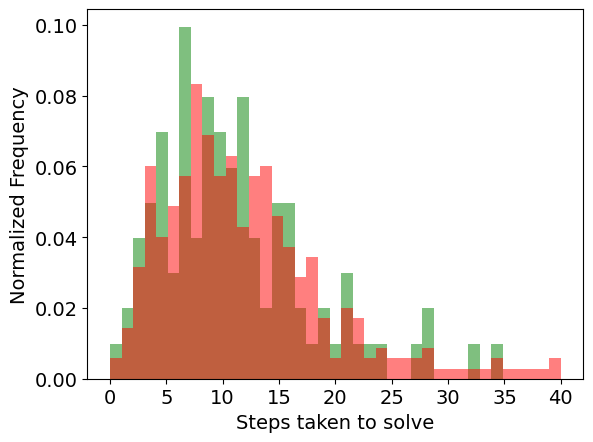

(100, 2)


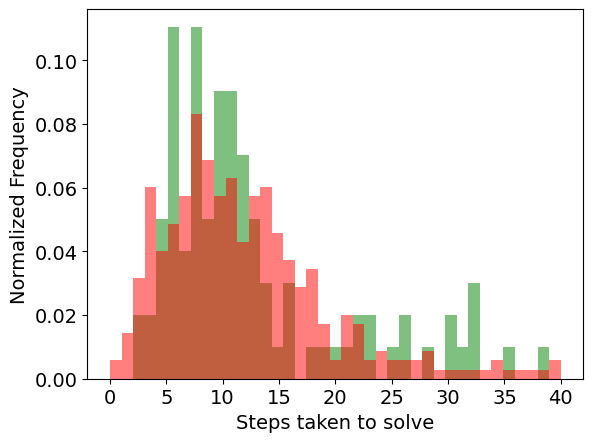

(100, 2)


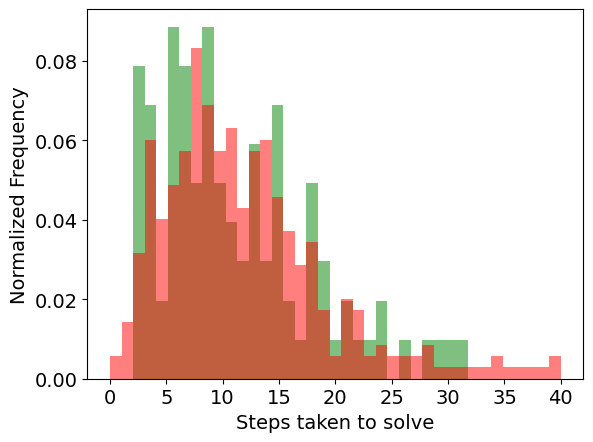

(100, 2)


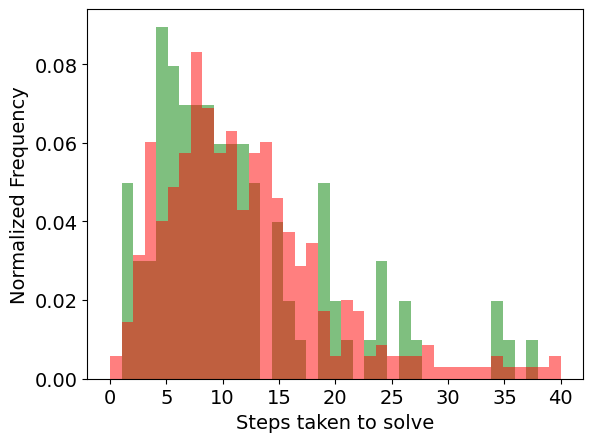

(100, 2)


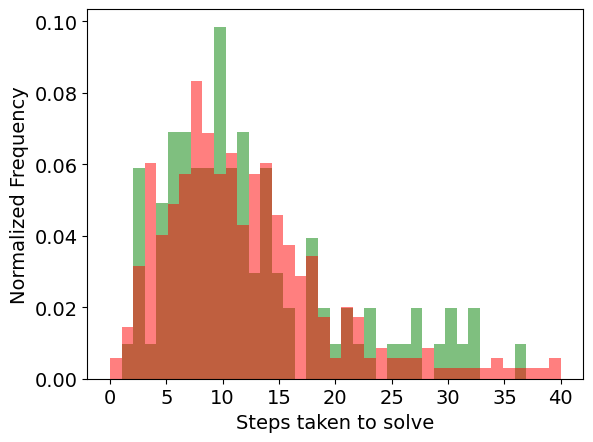

In [543]:
cross_30_15_30_0 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__0 (1).json'
cross_30_15_30_1 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__1 (1).json'
cross_30_15_30_2 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__2 (1).json'
cross_30_15_30_3 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__3 (1).json'
cross_30_15_30_4 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__4 (1).json'
cross_30_15_30_5 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__5 (1).json'
cross_30_15_30_6 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__6 (1).json'
cross_30_15_30_7 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__7 (1).json'
cross_30_15_30_8 = '/Users/athmajanvivekananthan/WCE/JEPA - MARL/multi-agent/PPO/bert_marl/mode30-dqn/bertsekas-marl/adaptation_30_15_30/cross_rollout_mode30__8 (1).json'

dataFilesList = [cross_30_15_30_0, cross_30_15_30_1, cross_30_15_30_2, cross_30_15_30_3, cross_30_15_30_4, cross_30_15_30_5, cross_30_15_30_6, cross_30_15_30_7, cross_30_15_30_8]

bin_edges = np.linspace(0, 40, 40)

sampleIndex = 1
cross30_15_30_Epochs_Total = []
window3_modelMean = []
window3_modelstd = []
for dataFile in dataFilesList:
    cross30_15_30_Epochs, cross30_15_30_Mean, cross30_15_30_std, listofTraining = getMean_STD2(dataFile)
    dfTraining = pd.DataFrame(listofTraining)
    print(dfTraining.shape)
    dfX_Window3 = dfTraining.iloc[::sampleIndex, :].reset_index()
    plt.hist(dfX_Window3["steps"].values.flatten(), bins=bin_edges, alpha=0.5, label='Autonomous MA Rollout', color='green', density=True)
    plt.hist(dfwindow3_baseline.values.flatten(), bins=bin_edges, alpha=0.5, label='Sequential Rollout', color='red', density=True)
    
    # Add labels and title
    plt.xlabel('Steps taken to solve', fontsize=14)
    plt.ylabel('Normalized Frequency', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add a legend
    #plt.legend()
    
    plt.savefig(f'./adaptation_files/window_3_histogram_plot_{epochPLot}.png', format='png')
    # Show the plot
    plt.show()



In [536]:
dfX_Window3

,index,episode,steps
0,0,0,8
1,2,2,12
2,4,4,13
3,6,6,3
4,8,8,7
5,10,10,6
6,12,12,12
7,14,14,18
8,16,16,9
9,18,18,10
